In [17]:
import numpy as np 
import pandas as pd
import pickle
import torch
import json
import matplotlib.pyplot as plt
import scipy.stats as st
import tqdm.notebook as tq
from utils.utils import *
from utils.models import *

# Preprocessing

In [4]:
mgh_results = torch.load("/Mounts/rbg-storage1/users/shared/Sybil/mgh_results.pt")
#metadata_mgh2 = json.load(open('/Mounts/rbg-storage1/datasets/MGH_Lung_Fintelmann/mgh_lung_cancer_cohort2v2.json'))
metadata_mgh = pd.read_pickle("/Mounts/rbg-storage1/users/shared/Sybil/mgh_data.p")
test_results = torch.load("/Mounts/rbg-storage1/users/shared/Sybil/nlst_test_results.pt")
metadata = pd.read_pickle("/Mounts/rbg-storage1/datasets/NLST/nlst_dataset.p")
metadata2 = pd.read_csv("/Mounts/rbg-storage1/datasets/NLST/package-nlst-564.2020-01-30/NLST_564/nlst_564.delivery.010220/nlst_564_prsn_20191001.csv", low_memory = True)

/Mounts/rbg-storage1/users/ayed/miniconda3/envs/expecto/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (201,224,225) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
map_races = {'Hispanic-OTHER@HISPANIC': 6, 'White-WHITE': 1, 'BLACK OR AFRICAN AMERICAN': 2, 'Other-OTHER': 6,
 'Not Recorded-DECLINED': 99, 'Not Recorded-@': 99, 'Hispanic-HISPANIC OR LATINO': 6,
 'Asian-ASIAN': 3, 'American Indian-AMERICAN INDIAN OR ALASKA NATIVE': 4, 
 'Not Recorded-UNKNOWN': 99, 'Hispanic White-WHITE@HISPANIC': 6,
 'Black-BLACK': 3,  'Hawaiian-NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 5, 'Hispanic-HISPANIC': 1, np.nan: 99}

mgh_data = pd.DataFrame(np.array(mgh_results["probs"]), columns=["risk_" + str(i+1) for i in range(6)])
mgh_data["exam"] = np.array(mgh_results["exams"])
mgh_data["golds"] = np.array(mgh_results["golds"])
mgh_metadata = pd.DataFrame([[metadata_mgh[i]["exam"], metadata_mgh[i]["age"],
  metadata_mgh[i]["race"], metadata_mgh[i]["pack_years"]] for i in range(len(metadata_mgh))],
            columns = ["exam", "age", "race", "smokeday"])

mgh_data = pd.merge(mgh_data, mgh_metadata, on = "exam", how = "left")
mgh_data["smokeday"] = (mgh_data["smokeday"] * 20) / 365
mgh_data["cigsmok"] = (mgh_data["smokeday"] > 0) * 1

mgh_data["race"] = mgh_data["race"].map(map_races)
mgh_data["institution"] = "mgh"
mgh_data = mgh_data.drop("exam", axis = 1)

keys_metadata = ["pid", "gender", "age", "race", "weight", "height", "diagcopd",
                 "cigsmok", "smokeyr", "smokeday"] + [key for key in metadata2.columns if key.startswith("fam")]

split_set = "test"

df_results = pd.DataFrame(np.array(test_results["probs"]), columns=["risk_" + str(i+1) for i in range(6)])
df_results.insert(0, "ID", np.array(test_results["exams"]))

df_results["golds"] = np.array(test_results["golds"])
df_results["censors"] = np.array(test_results["censors"])

df_metadata = pd.DataFrame([[metadata[split_set][i][key] for key in ["exam", "pid", "institution"]] 
                              for i in range(len(metadata[split_set]))],
                            columns = ["exam", "pid", "institution"])

df_metadata["pid"] = df_metadata["pid"].astype(int)

df_metadata = pd.merge(df_metadata, metadata2[keys_metadata], on = "pid", how = "left")

df_results = pd.merge(df_results, df_metadata, left_on = "ID", right_on = "exam", how = "left")

df_results["gender"] = df_results["gender"] - 1
df_results["bmi"] = 703 * df_results["weight"] / df_results["height"] ** 2

df_results["fam_history"] = (sum([df_results[key] for key in metadata2.columns if key.startswith("fam")]) > 0) * 1

df_results = df_results.drop(columns = [key for key in metadata2.columns if key.startswith("fam")] + ["ID", "exam", "pid"], axis = 1)

# Group the small groups together?

n = 100

counts = df_results['institution'].value_counts()
df_results = df_results[df_results['institution'].isin(counts[counts > n].index)]

df_results = df_results.fillna(df_results.mean())

# Example experiment: fixed n

In [8]:
num_experiments = 10 
n = 200 
len_mgh = len(mgh_data)

# Initialize empty DataFrames to store the results
results = pd.DataFrame()
coverage = pd.DataFrame()
npv = pd.DataFrame()

# Single loop to iterate over experiments and alpha values
for a in tq.tqdm(range(num_experiments)):
    alpha_values = np.linspace(0.1, 0.5, 9)
    
    # Call the pipeline function once for each experiment
    pipeline_results = [pipeline_multi(df = df_results, df_mgh = mgh_data, alpha=i, upsample=False, frac_sample=n/len_mgh, 
                                 random_state=a, include_target = True) for i in alpha_values]

    # Calculate results and coverage for each alpha value
    #results[a] = [np.maximum(i - result["alpha_emp"], 0) for i,result in zip(alpha_values, pipeline_results)]
    results[a] = [np.abs(i - result["alpha_emp"]) for i,result in zip(alpha_values, pipeline_results)]
    coverage[a] = [result["coverage"] for result in pipeline_results]
    npv[a] = [result["npv"] for result in pipeline_results]

  0%|          | 0/10 [00:00<?, ?it/s]

# Example experiment: fixed alpha, varying n

In [21]:
alpha = 0.25
num_experiments = 10
len_mgh = len(mgh_data)

error_estimator = []
error_is = []
error_multi = []

coverage_estimator = []
coverage_is = []
coverage_multi = []

for a in tq.tqdm(range(num_experiments)):
    
    row_estimator_error = []
    row_is_error = []
    row_multi_error = []
    
    row_estimator_coverage = []
    row_is_coverage = []
    row_multi_coverage = []
    
    for i in range(100, 1001, 50):
        
        is_results = pipeline_merged(df = df_results, df_mgh = mgh_data, alpha = alpha, upsample = False, frac_sample = i/len_mgh, 
          random_state = a)
        
        estimator_results = simple_estimator(df = mgh_data, alpha = alpha, frac_sample = i/len_mgh, random_state = a)
        
        multi_results = pipeline_multi(df = df_results, df_mgh = mgh_data, alpha = alpha, upsample = False, frac_sample = i/len_mgh, 
          random_state = a, weighted = True, include_target = True)
        
        #row_is_error.append(np.maximum(alpha - is_results["alpha_emp"], 0))
        #row_estimator_error.append(np.maximum(alpha - estimator_results["alpha_emp"], 0))
        row_is_error.append(np.abs(is_results["alpha_emp"] - alpha))
        row_estimator_error.append(np.abs(estimator_results["alpha_emp"] - alpha))
        row_multi_error.append(np.abs(multi_results["alpha_emp"] - alpha))
        
    error_estimator.append(row_estimator_error)
    error_is.append(row_is_error)
    error_multi.append(row_multi_error)
    
error_estimator = pd.DataFrame(error_estimator)
error_is = pd.DataFrame(error_is)
error_multi = pd.DataFrame(error_multi)

coverage_estimator = pd.DataFrame(coverage_estimator)
coverage_is = pd.DataFrame(coverage_is)
coverage_multi = pd.DataFrame(coverage_multi)

  0%|          | 0/10 [00:00<?, ?it/s]

/Mounts/rbg-storage1/users/ayed/miniconda3/envs/expecto/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
/Mounts/rbg-storage1/users/ayed/miniconda3/envs/expecto/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
/Mounts/rbg-storage1/users/ayed/miniconda3/envs/expecto/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: S

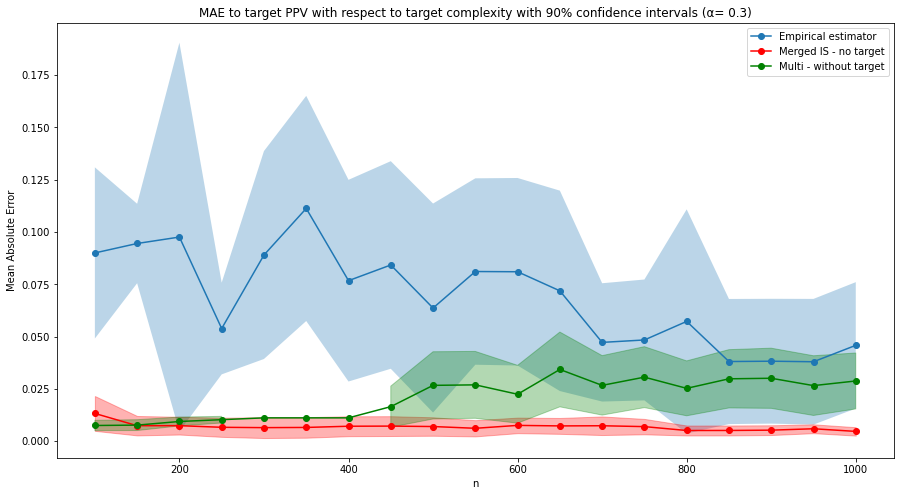

In [19]:
# Define x values
x = list(range(100, 1001, 50))

# Generate random error estimator data for the first curve
y = error_estimator.mean(axis=0)
error = np.array([st.t.interval(0.9, len(error_estimator[a])-1, loc=np.nanmean(error_estimator[a]), scale=st.sem(error_estimator[a], nan_policy='omit')) for a in range(len(x))])
lower_bound = error[:, 0]
upper_bound = error[:, 1]

# Generate random error estimator data for the second curve
y2 = error_is.mean(axis=0)
error2 = np.array([st.t.interval(0.9, len(error_is[a])-1, loc=np.nanmean(error_is[a]), scale=st.sem(error_is[a], nan_policy='omit')) for a in range(len(x))])
lower_bound2 = error2[:, 0]
upper_bound2 = error2[:, 1]

# Generate random error estimator data for the third curve
y3 = error_multi.mean(axis=0)
error3 = np.array([st.t.interval(0.9, len(error_multi[a])-1, loc=np.nanmean(error_multi[a]), scale=st.sem(error_multi[a], nan_policy='omit')) for a in range(len(x))])
lower_bound3 = error3[:, 0]
upper_bound3 = error3[:, 1]

# Create a DataFrame with x, y, and error values for all curves
data = pd.DataFrame({'x': x, 'y': y, 'y2': y2, 'y3': y3,
                     'lower_bound': lower_bound, 'upper_bound': upper_bound,
                     'lower_bound2': lower_bound2, 'upper_bound2': upper_bound2,
                     'lower_bound3': lower_bound3, 'upper_bound3': upper_bound3})

plt.figure(figsize=(15, 8))

# Plot curve with fill_between for the first curve
plt.plot('x', 'y', data=data, marker='o', label='Empirical estimator')
plt.fill_between(data['x'], data['lower_bound'], data['upper_bound'], alpha=0.3)

# Plot curve with fill_between for the second curve
plt.plot('x', 'y2', data=data, marker='o', color='red', label='Merged IS - no target')
plt.fill_between(data['x'], data['lower_bound2'], data['upper_bound2'], alpha=0.3, color='red')

# Plot curve with fill_between for the third curve
plt.plot('x', 'y3', data=data, marker='o', color='green', label='Multi - without target')
plt.fill_between(data['x'], data['lower_bound3'], data['upper_bound3'], alpha=0.3, color='green')

# Set labels, legend, and title
plt.xlabel('n')
plt.ylabel('Mean Absolute Error')
plt.title('MAE to target PPV with respect to target complexity with 90% confidence intervals (' + chr(945) + '= ' + str(alpha) + ')')
plt.legend()

# Show the plot
plt.show()